In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from tqdm import tqdm
import imageio
import torch
import torch.distributions as dist

from pybpl.library import Library
from pybpl.ctd import CharacterTypeDist
from pybpl.concept import Character, CharacterToken
from pybpl.part import Stroke, StrokeToken
from pybpl.relation import *
#from pybpl.parameters import defaultps
from pybpl import rendering

In [2]:
# library and type distribution
lib = Library('../lib_data/')
type_dist = CharacterTypeDist(lib)

In [3]:
# for better image visualization in matplotlib
def box_only(obj):
    obj.tick_params(
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False
    )

## first, load the target image

In [4]:
img_target = imageio.imread('./image_H.jpg')
img_target = np.asarray(img_target, dtype=np.float32) / 255.

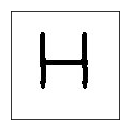

In [5]:
plt.figure(figsize=(2,2))
plt.imshow(img_target, cmap='Greys')
box_only(plt)
plt.show()

## Now, create an initial "H" type and token that we will optimize

In [6]:
def initial_type_and_token():
    # first stroke has 1 sub-stroke, with id "0"
    s1 = Stroke(
        nsub=torch.tensor(1), 
        ids=torch.tensor([0]),
        shapes=type_dist.shapes_mu[0].view(5, 2, 1),
        invscales=torch.tensor([0.5]),
        lib=lib
    )
    r1 = RelationIndependent(
        category='unihist',
        gpos=torch.tensor([30., -22.]),
        lib=lib
    )
    # second stroke has 1 sub-stroke, with id "9"
    s2 = Stroke(
        nsub=torch.tensor(1), 
        ids=torch.tensor([9]),
        shapes=type_dist.shapes_mu[9].view(5, 2, 1),
        invscales=torch.tensor([0.4]),
        lib=lib
    )
    r2 = RelationAttachAlong(
        category='mid',
        attach_ix=0,
        attach_subix=0,
        eval_spot=4.5,
        lib=lib
    )
    # third stroke has 1 sub-stroke, with id "0"
    s3 = Stroke(
        nsub=torch.tensor(1), 
        ids=torch.tensor([0]),
        shapes=type_dist.shapes_mu[0].view(5, 2, 1),
        invscales=torch.tensor([0.5]),
        lib=lib
    )
    r3 = RelationIndependent(
        category='unihist',
        gpos=torch.tensor([70., -22.]),
        lib=lib
    )
    k = torch.tensor(3)
    P = [s1, s2, s3]
    R = [r1, r2, r3]
    # initialize the type
    char = Character(k, P, R, lib)
    # sample an initial token
    token = char.sample_token()
    
    return char, token

## Get optimizable variables

In [7]:
def get_optimizable_variables(ctype, ctoken, eps):
    assert isinstance(ctype, Character)
    assert isinstance(ctoken, CharacterToken)
    parameters = []
    lbs = []
    ubs = []
    names = []
    for i in range(ctype.k):
        # shapes type
        ctype.P[i].shapes.requires_grad_()
        parameters.append(ctype.P[i].shapes)
        lbs.append([])
        ubs.append([])
        names.append('shapes_type_%i'%i)
        # shapes token
        ctoken.P[i].shapes.requires_grad_()
        parameters.append(ctoken.P[i].shapes)
        lbs.append([])
        ubs.append([])
        names.append('shapes_token_%i'%i)
        
        # scales type
        ctype.P[i].invscales.requires_grad_()
        parameters.append(ctype.P[i].invscales)
        lbs.append(torch.full(ctype.P[i].invscales.shape, eps))
        ubs.append([])
        names.append('invscales_type_%i'%i)
        # scales token
        ctoken.P[i].invscales.requires_grad_()
        parameters.append(ctoken.P[i].invscales)
        lbs.append(torch.full(ctoken.P[i].invscales.shape, eps))
        ubs.append([])
        names.append('invscales_token_%i'%i)

    return parameters, lbs, ubs, names

In [23]:
char, token = initial_type_and_token()
params, lbs, ubs, param_names = get_optimizable_variables(char, token, eps=1e-4)

/Users/rfeinman/src/pyBPL/pybpl/concept.py:230: UserWarning: skipping affine warp for now.
  warnings.warn('skipping affine warp for now.')
/Users/rfeinman/src/pyBPL/pybpl/concept.py:245: UserWarning: using fixed image noise for now.
  warnings.warn('using fixed image noise for now.')
/Users/rfeinman/src/pyBPL/pybpl/concept.py:261: UserWarning: using fixed image blur for now.
  warnings.warn('using fixed image blur for now.')


In [25]:
token.blur_sigma = 5.

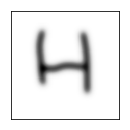

In [26]:
plt.figure(figsize=(2,2))
plt.imshow(token.pimg.detach().numpy(), cmap='Greys')
box_only(plt)
plt.show()

### optimize

In [27]:
nb_iter = 300
interval = 30 # how often we will log pimg status
lr = 5e-4
img_target = torch.tensor(img_target)

score_type_list = []
score_token_list = []
score_img_list = []
imgs = []
param_vals = []
optimizer = torch.optim.Adam(params, lr=lr)
for idx in tqdm(range(nb_iter)):
    if idx % interval == 0:
        # store pimg at this iteration for later viewing
        imgs.append(np.copy(token.pimg.detach().numpy()))
    # compute scores
    score_type = type_dist.score_type(char)
    score_token = char.score_token(token)
    score_img = token.score_image(img_target)
    score = score_type + score_token + score_img
    # append to lists
    score_type_list.append(score_type)
    score_token_list.append(score_token)
    score_img_list.append(score_img)
    param_vals.append([np.copy(p.detach().numpy()) for p in params])
    # first, zero all gradients
    optimizer.zero_grad()
    # now, perform backward pass
    score_neg = -score
    score_neg.backward()
    # optimization step
    optimizer.step()
    # clip params at boundaries
    with torch.no_grad():
        for ip, param in enumerate(params):
            lb = lbs[ip]
            ub = ubs[ip]
            if len(lb) > 0:
                torch.max(param, lb, out=param)
            if len(ub) > 0:
                torch.min(param, ub, out=param)

100%|██████████| 300/300 [01:04<00:00,  4.66it/s]


### check loss vs iteration

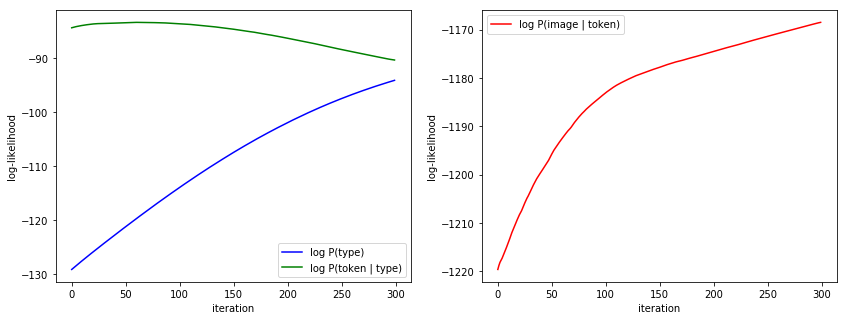

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
# type and token scores
axes[0].plot(score_type_list, c='b', label='log P(type)')
axes[0].plot(score_token_list, c='g', label='log P(token | type)')
axes[0].set_ylabel('log-likelihood')
axes[0].set_xlabel('iteration')
axes[0].legend()
# image score
axes[1].plot(score_img_list, c='r', label='log P(image | token)')
axes[1].set_ylabel('log-likelihood')
axes[1].set_xlabel('iteration')
axes[1].legend()
plt.show()

### check pimg vs iteration

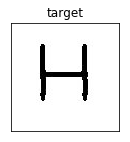

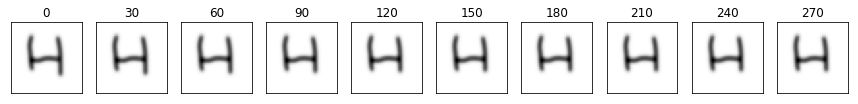

In [29]:
plt.figure(figsize=(2,2))
plt.imshow(img_target, cmap='Greys')
box_only(plt)
plt.title('target')
plt.show()
print('')

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(imgs[i], cmap='Greys')
    box_only(axes[i])
    axes[i].set_title('%i' % (interval*i))
plt.show()